In [1]:
%matplotlib inline
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import gym

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
%matplotlib notebook

Finished:
- Baseline BRS with large parameters range: **std & v - \[1e-3, 1\]** (all buffer)
- Baseline BRS with small parameters range **std & v\[1e-3, 10\]** (all buffer)
- Baseline BRS with random sampling (n_samples random samples form buffer) `std=1e-3`
- Baseline BRS with sorted sampling (n_samples sorted samples form buffer)

TODO:
List of things to check:
- VARIABLES:
    - Random seed vs total_mean_reward(TMR)
    - N_ROLLOUTS vs TMR
    - TOTAL_STEPS vs TMR
    - b=2
    - alpha=1e-3 
    - std=1
    - v=1e-3
    - States norm (minmax)

COMPONENTS:
- sample number unsorted vs sorted by reward 
- rollouts
- input data normalization

# Hyper Parameters and Ranges

In [4]:
# PARAMETERS

# Random seed 
SEED = 42
# Number of steps to wait until next update 
N_ROLLOUTS = 100
# Number of total steps of env simulation
TOTAL_STEPS = 1000
# Number of evaluation stapes 
EVAL_STEPS = 1000
#
# ALPHA = 1e-3 
# STD for normal dist. for exploration noise
# STD = 1
# Amount of noise we add (weight multiplyer)
# V = 1e-3

# Parameters ranges
# (min, max, step)
# SEED_RANGE = (0, 1024, 1)
# TOTAL_STEPS_RANGE = (1, 1e+5, 1)
# N_ROLLOUTS_RANGE = (0, TOTAL_STEPS_RANGE[1], 1)
# ALPHA_RANGE = (0, 1, 1e-3)
# STD_RANGE = (0, 1, 1e-3)
# V_RANGE = (0, 1, 1e-3)


# Model
In all experiments will be used one type of model.

In [5]:
class Linear_model:
    def __init__(self, n_state, n_action): 
        # M stands for parameters of this model
        self.M = np.zeros((n_action, n_state))
        
    def __call__(self, state, v=0, noise=1):
        '''
            v - [0.,1.] controls how much noise we adding to our parameters
            noise - noise of same shape as M
        '''
        action = (self.M + v*noise) @ state
        return action

In [6]:
class Linear_model_v2:
    def __init__(self, n_state, n_action): 
        # M stands for parameters of this model
        self.M = np.zeros((n_action, n_state))
        self.mu = np.zeros((n_state))
        self.sigma = np.ones(n_state)
        
    def __call__(self, state, v=0, noise=1):
        '''
            v - [0.,1.] controls how much noise we adding to our parameters
            noise - noise of same shape as M
        '''
        # [(n_action, n_state) + (n_action, n_state)] @ (n_state,n_state) @ [(n_state, 1) - (n_state, 1)]
        _sigma = np.diag(self.sigma)
        action = (self.M + v*noise) @ _sigma @ (state - self.mu)
        return action

# Optimizers

In [7]:
'''
BRS_v1    (V1 model with simple update)
'''
class BaseRandomSearch:
    def __init__(self, n_state, n_action, std, v):
        self.policy = Linear_model(n_state,n_action)
        self.std = std
        self.v = v
        
        self.buffer = []
        
    def get_actions(self, state, is_train=False):
        if is_train:
            noise = np.random.normal(0, self.std, size=self.policy.M.shape)
            action_pos = self.policy(state,  self.v, noise)
            action_neg = self.policy(state, -self.v, noise)
            action_pos = self._remap_actions(action_pos)
            action_neg = self._remap_actions(action_neg)
            return action_pos, action_neg, noise
        else:
            action = self.policy(state)
            return self._remap_actions(action)
        
    def learn(self):
        update = np.zeros_like(self.policy.M)
        for step in self.buffer:
            if self.v == 0:
                update = 0
            else:
                update += ((step[-2] - step[-1]) * step[-3]) / self.v
        
        self.policy.M = self.policy.M + update  
        
        self.buffer = []
        
    def remember(self, memory):
        self.buffer.append(memory)
        
    def _remap_actions(self, action):
        return 2*np.tanh(action)
            

In [8]:
'''
BRS_v1_RS (V1 model with random subset buffer update)
'''
class BRS_RS(BaseRandomSearch):
    def __init__(self, n_state, n_action, std, v, n_samples):
        self.policy = Linear_model(n_state,n_action)
        self.std = std
        self.v = v
        self.n_samples = n_samples
        
        self.buffer = []
        
    def learn(self):
        update = np.zeros_like(self.policy.M)
        
        buffer_idxs = np.random.choice(np.arange(len(self.buffer)), self.n_samples)
        buffer = np.array(self.buffer, dtype=object)[buffer_idxs]
        
        for step in buffer:
            if self.v == 0:
                update = 0
            else:
                update += ((step[-2] - step[-1]) * step[-3]) / self.v
        
        self.policy.M = self.policy.M + update  
        
        self.buffer = []
        
            

In [9]:
'''
BRS_v1_SS (V1 model with sorted subset buffer update)
'''
class BRS_SS(BRS_RS):
    def _sort_directions(self):
        buffer = np.array(self.buffer, dtype=object)
        b_rewards = buffer[:, -2:].sum(-1)

        # idxs from low to high
        b_idxs = np.argsort(b_rewards)
        b_buffer = buffer[b_idxs][-self.n_samples:]

        return b_buffer

    def learn(self):
        update = np.zeros_like(self.policy.M)
        
        buffer = self._sort_directions()
        
        for step in buffer:
            if self.v == 0:
                update = 0
            else:
                update += ((step[-2] - step[-1]) * step[-3]) / self.v
        
        self.policy.M = self.policy.M + update  
        
        self.buffer = []
        
            

In [10]:
'''
BRS_v2    (V2 model with simple update)
'''
class BaseRandomSearch_v2:
    def __init__(self, n_state, n_action, std, v):
        self.policy = Linear_model_v2(n_state,n_action)
        self.std = std
        self.v = v
        
        self.buffer = []
        self.states = []
        
    def get_actions(self, state, is_train=False):
        if is_train:
            noise = np.random.normal(0, self.std, size=self.policy.M.shape)
            action_pos = self.policy(state,  self.v, noise)
            action_neg = self.policy(state, -self.v, noise)
            action_pos = self._remap_actions(action_pos)
            action_neg = self._remap_actions(action_neg)
            return action_pos, action_neg, noise
        else:
            action = self.policy(state)
            return self._remap_actions(action)
        
    def learn(self):
        update = np.zeros_like(self.policy.M)
        for step in self.buffer:
            if self.v == 0:
                update = 0
            else:
                update += ((step[-2] - step[-1]) * step[-3]) / self.v
        
        self.policy.M = self.policy.M + update  
        
        self.policy.mu = np.mean(self.states, 0)
        self.policy.sigma = np.std(self.states, 0)
        
        self.buffer = []
        
    def remember(self, memory):
        # pos_action, neg_action, noise, pos_reward, neg_reward
        self.buffer.append(memory)
        
    def _remap_actions(self, action):
        return 2*np.tanh(action)
            

In [11]:
'''
BRS_v2_RS (V2 model with random subset buffer update)
'''
class BRS_v2_RS(BaseRandomSearch_v2):
    def __init__(self, n_state, n_action, std, v, n_samples):
        self.policy = Linear_model_v2(n_state,n_action)
        self.std = std
        self.v = v
        self.n_samples = n_samples
        
        self.buffer = []
        self.states = []
        
    def learn(self):
        update = np.zeros_like(self.policy.M)
        
        buffer_idxs = np.random.choice(np.arange(len(self.buffer)), self.n_samples)
        buffer = np.array(self.buffer, dtype=object)[buffer_idxs]
        
        for step in buffer:
            if self.v == 0:
                update = 0
            else:
                update += ((step[-2] - step[-1]) * step[-3]) / self.v
        
        self.policy.M = self.policy.M + update 
        
        self.policy.mu = np.mean(self.states, 0)
        self.policy.sigma = np.std(self.states, 0)
        
        self.buffer = []

In [12]:
'''
BRS_v2_SS (V2 model with sorted subset buffer update)
'''
class BRS_v2_SS(BRS_v2_RS):
    def _sort_directions(self):
        buffer = np.array(self.buffer, dtype=object)
        b_rewards = buffer[:, -2:].sum(-1)

        # idxs from low to high
        b_idxs = np.argsort(b_rewards)
        b_buffer = buffer[b_idxs][-self.n_samples:]

        return b_buffer

    def learn(self):
        update = np.zeros_like(self.policy.M)
        
        buffer = self._sort_directions()
        
        for step in buffer:
            if self.v == 0:
                update = 0
            else:
                update += ((step[-2] - step[-1]) * step[-3]) / self.v
        
        self.policy.M = self.policy.M + update
        
        self.policy.mu = np.mean(self.states, 0)
        self.policy.sigma = np.std(self.states, 0)
        
        self.buffer = []
        

In [33]:
'''
ARS_v1
'''
class ARS_v1:
    def __init__(self, n_state, n_action, std, n_samples, alpha=1e-3):
        self.policy = Linear_model(n_state,n_action)
        self.std = std
        self.alpha = alpha
        self.n_samples = n_samples
        
        self.buffer = []
        
    def get_actions(self, state, is_train=False):
        if is_train:
            noise = np.random.normal(0, self.std, size=self.policy.M.shape)
            action_pos = self.policy(state,  self.v, noise)
            action_neg = self.policy(state, -self.v, noise)
            action_pos = self._remap_actions(action_pos)
            action_neg = self._remap_actions(action_neg)
            return action_pos, action_neg, noise
        else:
            action = self.policy(state)
            return self._remap_actions(action)
    
    def _sort_directions(self):
        buffer = np.array(self.buffer, dtype=object)
        b_rewards = buffer[:, -2:].sum(-1)

        # idxs from low to high
        b_idxs = np.argsort(b_rewards)
        b_buffer = buffer[b_idxs][-self.n_samples:]

        return b_buffer

    def learn(self):
        b_buffer = self._sort_directions()
        update = np.zeros_like(self.policy.M)
        
        for step in b_buffer:
            r_p = step[-2]
            r_n = step[-1]
            noise = step[-3]
            update += ((r_p - r_n) * noise)
        
        reward_std = b_buffer[:, -2:].std()
        norm = self.alpha / (self.n_samples * reward_std)
        
        
        self.policy.M = self.policy.M + (norm * update)
        
        self.buffer = []
        
    def remember(self, memory):
        # pos_action, neg_action, noise, pos_reward, neg_reward
        self.buffer.append(memory)
        
    def _remap_actions(self, action):
        return 2*np.tanh(action)
            

In [ ]:
'''
ARS_v2
'''
class ARS_v2:
    def __init__(self, n_state, n_action, std, v, n_samples):
        self.policy = Linear_model_v2(n_state,n_action)
        self.std = std
        self.v = v
        
        self.buffer = []
        self.states = []
        
    def get_actions(self, state, is_train=False):
        if is_train:
            noise = np.random.normal(0, self.std, size=self.policy.M.shape)
            action_pos = self.policy(state,  self.v, noise)
            action_neg = self.policy(state, -self.v, noise)
            action_pos = self._remap_actions(action_pos)
            action_neg = self._remap_actions(action_neg)
            return action_pos, action_neg, noise
        else:
            action = self.policy(state)
            return self._remap_actions(action)
        
    def learn(self):
        update = np.zeros_like(self.policy.M)
        for step in self.buffer:
            if self.v == 0:
                update = 0
            else:
                update += ((step[-2] - step[-1]) * step[-3]) / self.v
        
        self.policy.M = self.policy.M + update  
        
        self.policy.mu = np.mean(self.states, 0)
        self.policy.sigma = np.std(self.states, 0)
        
        self.buffer = []
        
    def remember(self, memory):
        # pos_action, neg_action, noise, pos_reward, neg_reward
        self.buffer.append(memory)
        
    def _remap_actions(self, action):
        return 2*np.tanh(action)
            

## Help functions

In [13]:
def train(env, t_model, total_steps, n_rollouts, tseed, version='v1'):
    np.random.seed(tseed)
    try:
        observation = env.reset(seed=tseed)
    except:
        env.seed(tseed)
        observation = env.reset()
        
    for step in range(total_steps):
        for ro in range(n_rollouts):
            pos_action, neg_action, noise = t_model.get_actions(observation, is_train=True)
            pos_observation, pos_reward, pos_done, pos_info = env.step(pos_action)
            neg_observation, neg_reward, neg_done, neg_info = env.step(neg_action)
            
            
            if version == 'v1':
                t_model.remember([pos_action[0], neg_action[0], noise[0], pos_reward, neg_reward])
            elif version == 'v2':
                t_model.states += pos_observation, neg_observation
                t_model.remember([pos_action[0], neg_action[0], noise[0], pos_reward, neg_reward])
            else:
                print(0/0)
                
            coin = np.random.rand() 
            if coin <= 0.05:
                observation = env.reset()
            elif 0.05 < coin < 0.47:
                observation = pos_observation 
            elif coin >= 0.47:
                observation = neg_observation
                
            if (pos_done or neg_done):
                observation = env.reset()
            
        t_model.learn()

    env.close()
    return t_model

In [14]:
def evaluate(env, model, eval_steps, eseed):
    np.random.seed(eseed)
    try:
        observation = env.reset(seed=eseed)
    except:
        env.seed(eseed)
        observation = env.reset()
        
    score = 0

    for step in range(eval_steps):
        action = model.get_actions(observation)
        observation, reward, done, info = env.step(action)

        score += reward

        if done:
            observation = env.reset()

    env.close()
    return score

In [15]:
def search_4_params(STD_RANGE, V_RANGE, TOTAL_STEPS, N_ROLLOUTS, SEED, EVAL_STEPS):
    env = gym.make('Pendulum-v1', g=9.81)
    n_action = 1 
    n_state = 3

    monitor = []
    saved_polices = []
    for std in tqdm(np.arange(*STD_RANGE)):
        for v in tqdm(np.arange(*V_RANGE), leave=False):
            model = BaseRandomSearch(n_state, n_action, std=std, v=v)

            trained_model = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED)
            score = evaluate(env, trained_model,EVAL_STEPS, SEED)
            monitor.append([std, v, score])
            saved_polices += [model.policy.M]
    monitor = np.array(monitor)
    return monitor, saved_polices

In [16]:
def display_std__v_r(monitor):
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.scatter3D(monitor[:,0], monitor[:,1], monitor[:,2], c=monitor[:,2], cmap='viridis_r')

    ax.set_xlabel('STD')
    ax.set_ylabel('V')
    ax.set_zlabel('Reward')

    plt.show()

# Ablation study

Train BRS

In [17]:
# STD_RANGE = (1e-3, 1, 8e-2)
# V_RANGE = (1e-3, 1, 8e-2)
# monitor_1, sp1 = search_4_params(STD_RANGE, V_RANGE, TOTAL_STEPS, N_ROLLOUTS, SEED, EVAL_STEPS)

# STD_RANGE = (1e-3, 0.02, 1e-3)
# V_RANGE = (1, 110, 10)
# monitor_2, sp2 = search_4_params(STD_RANGE, V_RANGE, TOTAL_STEPS, N_ROLLOUTS, SEED, EVAL_STEPS)

# STD_RANGE = (1e-3, 0.002, 1e-4)
# V_RANGE = (10, 1100, 100)
# monitor_3, sp3 = search_4_params(STD_RANGE, V_RANGE, TOTAL_STEPS, N_ROLLOUTS, SEED, EVAL_STEPS)


In [18]:
# display_std__v_r(monitor_1)

In [19]:
# display_std__v_r(monitor_2)

In [20]:
# display_std__v_r(monitor_3)

In [21]:
# fig, ax = plt.subplots()
# D = [monitor_1[:,2], monitor_2[:,2], monitor_3[:,2]]
# b = ax.boxplot(D)

# ax.set_xlabel('Model')
# ax.set_ylabel('Reward')
# plt.show()

Now we showed that optimal values for parameters on simple BRS model are:  
```
STD = 1.5e-3
V = 100
```  
We can proceed further with those fixed, for reprodusability and purposes of fair comparison.  
Also we can check differences between policies learn by each model.

In [22]:
# print('Sample of learned polices:')
# print('Monitor 1:')
# [print(v) for v in sp1[:3]]
# print('Monitor 2:')
# [print(v) for v in sp2[:3]]
# print('Monitor 3:')
# [print(v) for v in sp3[:3]]

F

In [23]:
STD = 1e-3
V = 1e-3
TOTAL_STEPS = 1000
N_ROLLOUTS = 100

N_SAMPLES_UPDATE = N_ROLLOUTS//2

np.random.seed(SEED)
RANDOM_EVAL_SEEDS = np.random.randint(10000, size=100)

env = gym.make('Pendulum-v1', g=9.81)
n_action = 1 
n_state = 3

## BRS_v1

In [24]:
model = BaseRandomSearch(n_state, n_action, std=STD, v=V)

trained_model = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED)

BRS_v1_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model, EVAL_STEPS, int(eseed))
    BRS_v1_rewards += [score]

  0%|          | 0/100 [00:00<?, ?it/s]

## BRS_v1_RS

In [25]:
model = BRS_RS(n_state, n_action, std=STD, v=V, n_samples=N_SAMPLES_UPDATE)

trained_model = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED)

BRS_v1_RS_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model, EVAL_STEPS, int(eseed))
    BRS_v1_RS_rewards += [score]

  0%|          | 0/100 [00:00<?, ?it/s]

## BRS_v1_SS

In [26]:
model = BRS_SS(n_state, n_action, std=STD, v=V, n_samples=N_SAMPLES_UPDATE)

trained_model = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED)

BRS_v1_SS_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model, EVAL_STEPS, int(eseed))
    BRS_v1_SS_rewards += [score]

  0%|          | 0/100 [00:00<?, ?it/s]

## BRS_v2

In [27]:
model = BaseRandomSearch_v2(n_state, n_action, std=STD, v=V)

trained_model = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED, version='v2')

BRS_v2_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model, EVAL_STEPS, int(eseed))
    BRS_v2_rewards += [score]

  0%|          | 0/100 [00:00<?, ?it/s]

## BRS_v2_RS

In [28]:
model = BRS_v2_RS(n_state, n_action, std=STD, v=V, n_samples=N_SAMPLES_UPDATE)

trained_model = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED, version='v2')

BRS_v2_RS_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model, EVAL_STEPS, int(eseed))
    BRS_v2_RS_rewards += [score]

  0%|          | 0/100 [00:00<?, ?it/s]

## BRS_v2_SS

In [29]:
model = BRS_v2_SS(n_state, n_action, std=STD, v=V, n_samples=N_SAMPLES_UPDATE)

trained_model = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED, version='v2')

BRS_v2_SS_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model, EVAL_STEPS, int(eseed))
    BRS_v2_SS_rewards += [score]


  0%|          | 0/100 [00:00<?, ?it/s]

## ARS_v1

In [34]:
model = ARS_v1(n_state, n_action, std=STD, n_samples=N_SAMPLES_UPDATE)

trained_model = train(env, model, TOTAL_STEPS, N_ROLLOUTS, SEED, version='v2')

ARS_v1_rewards = []
for eseed in tqdm(RANDOM_EVAL_SEEDS):
    score = evaluate(env, trained_model, EVAL_STEPS, int(eseed))
    ARS_v1_rewards += [score]


AttributeError: 'ARS_v1' object has no attribute 'v'

<IPython.core.display.Javascript object>


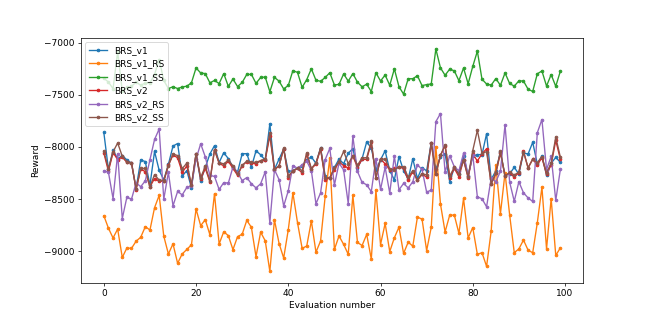

In [30]:
D = [BRS_v1_rewards, BRS_v1_RS_rewards, BRS_v1_SS_rewards, 
     BRS_v2_rewards, BRS_v2_RS_rewards, BRS_v2_SS_rewards]

labels = ['BRS_v1', 'BRS_v1_RS', 'BRS_v1_SS', 
          'BRS_v2', 'BRS_v2_RS', 'BRS_v2_SS']

plt.figure(figsize=(10,5))
for i, d in enumerate(D):
    plt.plot(d, '.-', label=labels[i])

    
plt.ylabel('Reward')
plt.xlabel('Evaluation number')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


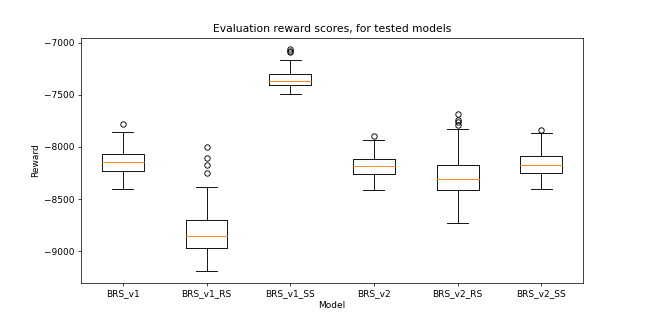

In [31]:
fig, ax = plt.subplots(figsize=(10,5))
b = ax.boxplot(D)

ax.set_xlabel('Model')
ax.set_ylabel('Reward')
ax.set_title('Evaluation reward scores, for tested models')

ax.set_xticklabels(labels)

plt.show()


In [44]:
BRS_v1_rewards[:3]

[-7268.473054866571, -7164.11736498168, -7094.488676420761]

In [45]:
BRS_v1_RS_rewards[:3]

[-7280.3285649124, -7302.713283023085, -7377.662363889126]

In [46]:
BRS_v1_SS_rewards[:3]

[-8105.7724210973065, -8300.421355091748, -8233.956995669512]

In [47]:
BRS_v2_rewards[:3]

[-8399.549941290114, -8749.548747454863, -9068.485532611632]

<IPython.core.display.Javascript object>


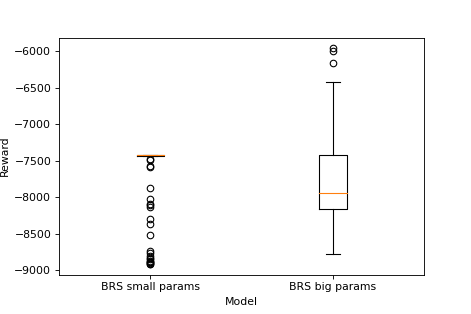

[Text(1, 0, 'BRS small params'), Text(2, 0, 'BRS big params')]

In [56]:
fig, ax = plt.subplots()
D = [monitor_sml[:,2], monitor_big[:,2]]
b = ax.boxplot(D)

ax.set_xlabel('Model')
ax.set_ylabel('Reward')

ax.set_xticklabels(['BRS small params', 'BRS big params'])

# plt.title('Reward: 1-small values; 2-big values')

Conclusion on this BRS baseline:  
no matter of parameters model sees same states and converges to same susboptimal state.

## BRS with random sampling


In [80]:
STD = 3 #1e-3
V_RANGE = (1, 10, 1)
N_SAMPLE_RANGE = (1, N_ROLLOUTS, 1)

env = gym.make('Pendulum-v1', g=9.82)
n_action = 1 
n_state = 3

monitor_rs = []
saved_polices = []
for n_samples in tqdm(np.arange(*N_SAMPLE_RANGE)):
    for v in tqdm(np.arange(*V_RANGE), leave=False):
        model = BRS_RS(n_state, n_action, std=STD, v=v, n_samples=n_samples)
        
        trained_model = train(env, model, STD, v)
        score = evaluate(env, trained_model)
        
        monitor_rs.append([n_samples, v, score])
        saved_polices += [model.policy.M]

monitor_rs = np.array(monitor_rs)

/home/ivan/miniconda3/envs/jn38/lib/python3.8/site-packages/gym/utils/env_checker.py:200: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

/home/ivan/miniconda3/envs/jn38/lib/python3.8/site-packages/gym/core.py:200: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


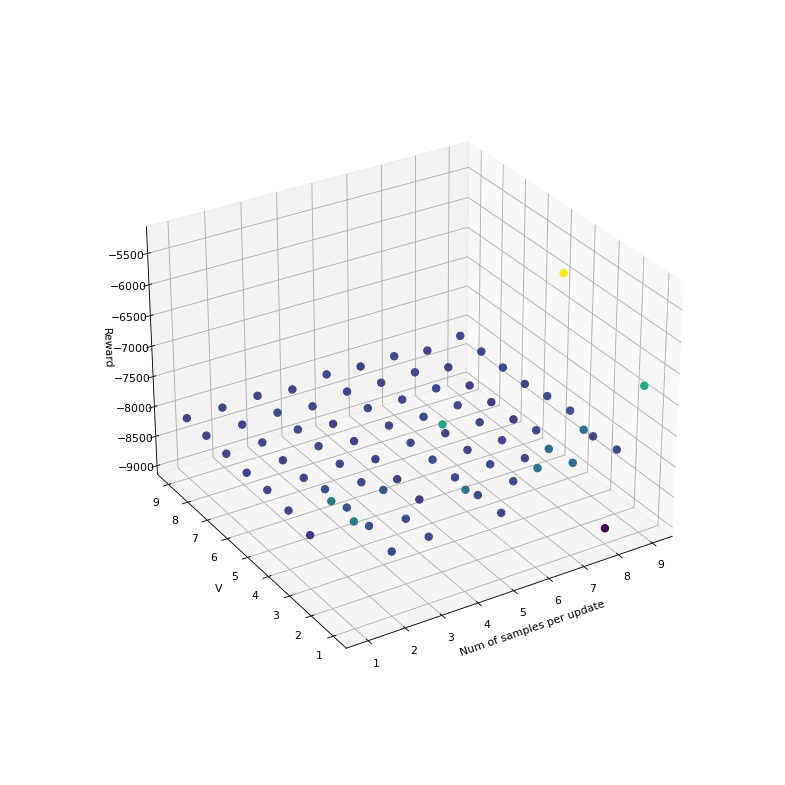

In [81]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(monitor_rs[:,0], monitor_rs[:,1], monitor_rs[:,2], c=monitor_rs[:,2], s=45, alpha=1)
# ax.view_init(10, 90)
ax.set_xlabel('Num of samples per update')
ax.set_ylabel('V')
ax.set_zlabel('Reward')
# ax.plot(monitor_rs[:,0], monitor_rs[:,1], monitor_rs[:,2], color='k')
plt.show()


<IPython.core.display.Javascript object>


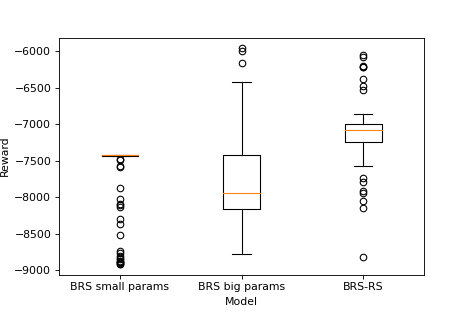

In [61]:
fig, ax = plt.subplots()
D = [monitor_sml[:,2], monitor_big[:,2], monitor_rs[:,2]]
b = ax.boxplot(D)

ax.set_xlabel('Model')
ax.set_ylabel('Reward')

ax.set_xticklabels(['BRS small params', 'BRS big params', 'BRS-RS'])

plt.show()

Conclusion for random sampling:  
Use of just random samples increses reward 

## BRS Sorted by reward trajectories 
Or BRS with Sorted Search (BRS-SS)

In [67]:
STD = 1e-3
V_RANGE = (1, 10, 1)
N_SAMPLE_RANGE = (1, N_ROLLOUTS, 1)

env = gym.make('Pendulum-v1', g=9.82)
n_action = 1 
n_state = 3

monitor_ss = []
#saved_polices = []
for n_samples in tqdm(np.arange(*N_SAMPLE_RANGE)):
    for v in tqdm(np.arange(*V_RANGE), leave=False):
        model = BRS_SS(n_state, n_action, std=STD, v=v, n_samples=n_samples)
        
        trained_model = train(env, model, STD, v)
        score = evaluate(env, trained_model)
        
        monitor_ss.append([n_samples, v, score])
        saved_polices += [model.policy.M]

monitor_ss = np.array(monitor_ss)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


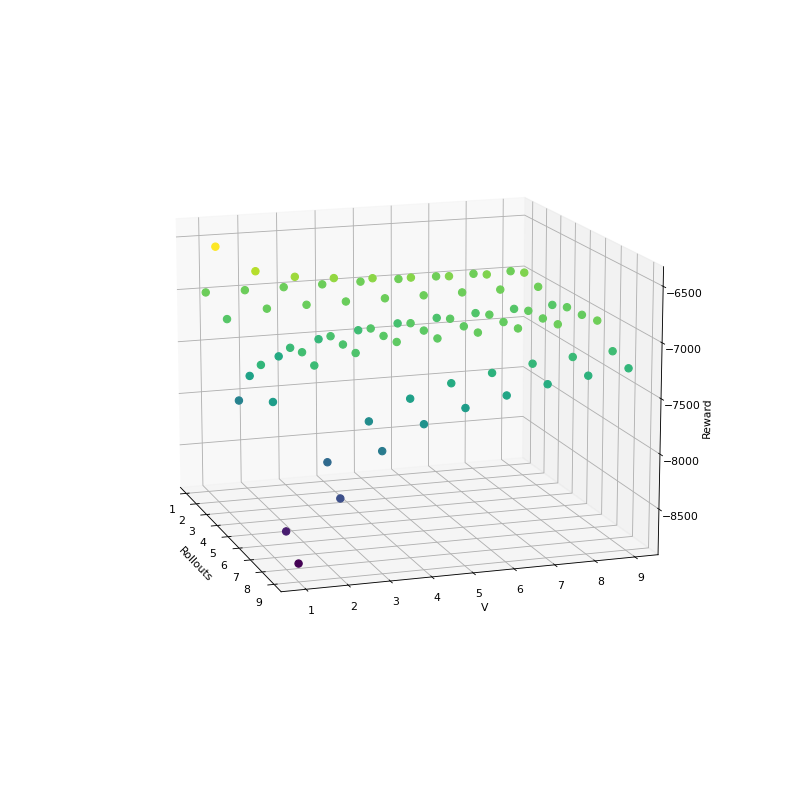

In [68]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(monitor_rs[:,0], monitor_ss[:,1], monitor_ss[:,2], c=monitor_ss[:,2], s=45, alpha=1)
# ax.view_init(10, 90)
ax.set_xlabel('Rollouts')
ax.set_ylabel('V')
ax.set_zlabel('Reward')
# ax.plot(monitor_rs[:,0], monitor_rs[:,1], monitor_rs[:,2], color='k')
plt.show()


<IPython.core.display.Javascript object>


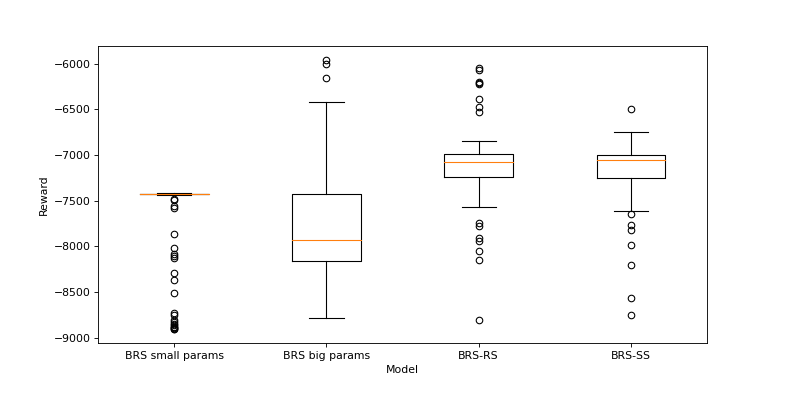

In [76]:
fig, ax = plt.subplots(figsize=(10,5))
D = [monitor_sml[:,2], monitor_big[:,2], monitor_rs[:,2], monitor_ss[:,2]]

box_plot = ax.boxplot(D)

ax.set_xlabel('Model')
ax.set_ylabel('Reward')

ax.set_xticklabels(['BRS small params', 'BRS big params', 'BRS-RS', 'BRS-SS'])

plt.show()

In [77]:
np.median(monitor_rs[:,2]) - np.median(monitor_ss[:,2])

-16.706225078600255

Looks like sorted BRS performs slightly better then random search. 

# Development

In [4]:
class ARS:
    def __init__(self, n_state, n_action, b=2, alpha=1e-3, std=1, v=1e-3,
                state_high=None, state_low=None):
        self.policy = Linear_model(n_state, n_action)
        self.buffer = []
        self.alpha = alpha
        self.std = std
        self.v = v
        # b - number of b top-performing directions 
        self.b = b
        
        self.state_low = state_low 
        self.state_high = state_high
        
    def learn(self):
        # sort noise permutations by reward they achive, 
        # and select only high reward ones
        b_buffer = self.sort_directions()
        
        reward_std = b_buffer[:, -2:].std()
        norm = self.alpha / (self.b * reward_std)
        
        reward_sum = 0
        for step in b_buffer:
            # ( R+ - R- ) * noise
            reward_sum += (step[-2] - step[-1]) * step[-3]
    
        self.policy.M = self.policy.M + (norm * reward_sum)
        
        # reset buffer 
        self.buffer = []
    
    def sort_directions(self):
        buffer = np.array(self.buffer, dtype=object)
        b_rewards = buffer[:, -2:].sum(-1)
        
        # idxs from low to high
        b_idxs = np.argsort(b_rewards)
        b_buffer = buffer[b_idxs][-self.b:]
        
        # print(buffer[b_idxs][:-self.b][:,-2:].mean(), buffer[b_idxs][-self.b:][:,-2:].mean())
        return b_buffer
    
    def get_actions(self, state, is_train=False):
        if not self.state_high is None:
            # MINMAX NORM {value - min}/{max - min}
            state = (state - self.state_low)/(self.state_high - self.state_low)
            
        if is_train:
            noise = np.random.normal(0,self.std, size=self.policy.M.shape)
            pos_action = self.policy(state,  self.v, noise)
            neg_action = self.policy(state, -self.v, noise)
            
            pos_action = self._remap_actions(pos_action)
            neg_action = self._remap_actions(neg_action)
            return pos_action, neg_action, noise
        else:
            action = self.policy(state)
            return self._remap_actions(action)
            
    
    def remember(self, memory):
        self.buffer.append(memory)
        
    def _remap_actions(self, action):
        return 2 * np.tanh(action)
    


In [5]:
import gym
env = gym.make('Pendulum-v1', g=9.82)
env.seed(SEED)
observation = env.reset()

state_high = env.observation_space.high
state_low = env.observation_space.low
model = ARS(3, 1, b=N_ROLLOUTS, std=1, 
            state_low=state_low, state_high=state_high)

REWARDS = []
t_reward = 0
for step in tqdm(range(TOTAL_STEPS)):
    #env.render()
    
    for ro in range(N_ROLLOUTS):
        pos_action, neg_action, noise = model.get_actions(observation, is_train=True)
        pos_observation, pos_reward, pos_done, pos_info = env.step(pos_action)
        neg_observation, neg_reward, neg_done, neg_info = env.step(neg_action)

        model.remember([pos_action[0], neg_action[0], noise, pos_reward, neg_reward])
        t_reward += (pos_reward + neg_reward)/2
        observation = env.reset()
        #observation = pos_observation if np.random.rand()>0.5 else neg_observation
    
    # if (pos_done or neg_done):
        
        
    # if (step % N_ROLLOUTS == 0 and step != 0):
    model.learn()
    REWARDS.append(t_reward)
    t_reward = 0
    
env.close()

100%|██████████| 100/100 [00:00<00:00, 1988.18it/s]


In [6]:
model.policy.M

array([[ 0.00088557,  0.00168218, -0.00120841]])

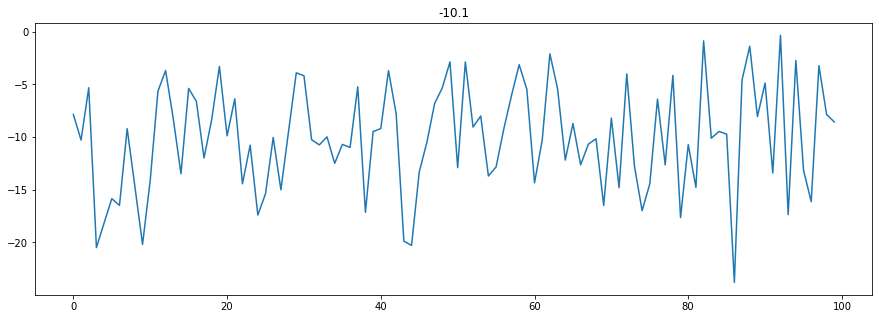

In [7]:
plt.figure(figsize=(15,5))
plt.plot(REWARDS)
plt.title(np.mean(REWARDS).round(1))
plt.show()

In [12]:
import pandas as pd

In [8]:
meta_data_collector = {''}



In [9]:
env = gym.make('Pendulum-v1', g=9.81)

np.random.seed(SEED)
env.seed(SEED)

observation = env.reset()

state_high = env.observation_space.high
state_low = env.observation_space.low


In [10]:
# EVALUATION
# env = gym.make('Pendulum-v1', g=9.82)
# observation = env.reset()

score = 0
for step in tqdm(range(EVAL_STEPS)):
    #env.render()
    
    action = model.get_actions(observation)
    observation, reward, done, info = env.step(action)
    
    score += reward
    
    if done:
        observation = env.reset()
        
env.close()
print(score)

100%|██████████| 1000/1000 [00:00<00:00, 18524.20it/s]

-6117.20509834359


In [1]:
# model = ARS(3, 1, b=N_ROLLOUTS, std=1, 
#             state_low=state_low, state_high=state_high)

# REWARDS = []
# t_reward = 0
# for step in tqdm(range(TOTAL_STEPS)):
#     #env.render()
    
#     for ro in range(N_ROLLOUTS):
#         pos_action, neg_action, noise = model.get_actions(observation, is_train=True)
#         pos_observation, pos_reward, pos_done, pos_info = env.step(pos_action)
#         neg_observation, neg_reward, neg_done, neg_info = env.step(neg_action)

#         model.remember([pos_action[0], neg_action[0], noise, pos_reward, neg_reward])
#         t_reward += (pos_reward + neg_reward)/2
#         #observation = env.reset()
#         observation = pos_observation if np.random.rand()>0.5 else neg_observation

#     model.learn()
#     REWARDS.append(t_reward)
#     t_reward = 0
    
# env.close()

In [1]:
# model.policy(np.array([1,1,0]))